# Linear Regression

Try to apply a linear regression model to the merged otu table

In [1]:
import csv
import logging

import biom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from src import project_directory
from src.database import get_session, Sample

In [2]:
session = get_session()
logging.basicConfig()
logging.getLogger('sqlalchemy.engine.Engine').setLevel(logging.ERROR)

Ok simply load otu table and then add tissue as metadata:

In [3]:
biom_file = project_directory / "merged_results/export/table/feature-table.biom"
table = biom.load_table(biom_file)

In [4]:
# Get the list of samples in the OTU table
samples = table.ids(axis='sample')
print(samples[:10])

['H_10_S10_L001' 'H_11_S11_L001' 'H_12_S12_L001' 'H_13_S13_L001'
 'H_14_S14_L001' 'H_15_S15_L001' 'H_16_S16_L001' 'H_17_S17_L001'
 'H_18_S18_L001' 'H_19_S19_L001']


In [5]:
# Query the database for samples in the samples list and collect the tissue
queried_samples = session.query(Sample).filter(Sample.sample_id.in_(samples)).all()
sample2tissue = {sample.sample_id: sample.dataset.tissue for sample in queried_samples}

In [6]:
# Create an empty dataframe with the same indices as the samples
metadata = pd.DataFrame(index=samples)

# Add the tissue as new metadata
metadata['tissue'] = metadata.index.map(sample2tissue)

# Update the OTU table with the new metadata
table.add_metadata(metadata.to_dict(orient='index'), axis='sample')

# Verify that the tissue has been added correctly
print(table.metadata(axis='sample')[:3])

(defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fcf3967efc0>, {'tissue': 'hindgut'}), defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fcf3967f560>, {'tissue': 'hindgut'}), defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fcf3967f600>, {'tissue': 'hindgut'}))


Transform the otu table to a pandas dataframe and then add the tissue as metadata.
Table should be transposed to have samples as rows and otus as columns.

In [7]:
# Convert the OTU table to a dataframe
otu_df = pd.DataFrame(table.matrix_data.toarray(), index=table.ids(axis='observation'), columns=table.ids(axis='sample'))

# Add the tissue metadata as a new column
otu_df = otu_df.transpose()
otu_df['tissue'] = otu_df.index.map(sample2tissue)

In [8]:
otu_df["tissue"].value_counts()

tissue
milk       379
gut        296
rumen      168
hindgut    141
Name: count, dtype: int64

Transform tables:

In [9]:
X = otu_df.drop(columns=["tissue"])
y = otu_df["tissue"]

In [10]:
# random_state:
# https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Creating a model

In [11]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [12]:
model = LogisticRegression(solver="liblinear", max_iter=1000)
ovr_classifier = OneVsRestClassifier(model)

In [13]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}

In [14]:
grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, verbose=1, cv=5)

In [ ]:
grid_search.fit(scaled_X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
grid_search.best_params_

{'C': 100, 'penalty': 'l1'}

In [ ]:
y_pred = grid_search.predict(scaled_X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.9791666666666666
Classification Report:
              precision    recall  f1-score   support

     hindgut       1.00      0.92      0.96        37
        milk       0.97      1.00      0.98       114
       rumen       1.00      0.98      0.99        41

    accuracy                           0.98       192
   macro avg       0.99      0.96      0.98       192
weighted avg       0.98      0.98      0.98       192



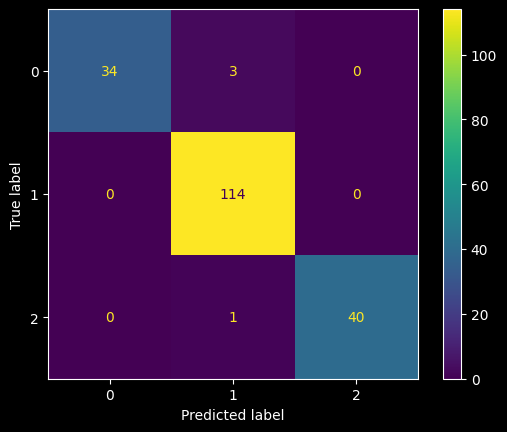

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Get the best model and save it to a file:

In [ ]:
best_model = grid_search.best_estimator_
joblib.dump(best_model, project_directory / "notebooks/logistic_regression_model.pkl")

['/home/cozzip/deep_micro_core/notebooks/logistic_regression_model.pkl']

Now try to collect the coefficients to identify the features that are more important for the model.

In [ ]:
coefficients = best_model.coef_[0]
feature_importance = pd.DataFrame({'Feature ID': X.columns, 'Coefficient': coefficients})
feature_importance['Importance'] = np.abs(feature_importance['Coefficient'])
feature_importance.set_index('Feature ID', inplace=True)
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance.head(10)

,Coefficient,Importance
Feature ID,,
0140adf2768afb9c1ebe97a2877450ef,0.330601,0.330601
f9428bb02d45d8596361bd394e37370a,0.230292,0.230292
9577d1852b3b182a5ba736d18bdea591,0.206860,0.206860
48e44ac5afd514ecc14bcd7d0b4745c4,0.200871,0.200871
15a7dfd509452e280228aef61897affa,0.180310,0.180310
c5fd03b13e4a898bbda7549a54a8ea75,0.180003,0.180003
0ae28a3863980315fda7156a61ccfdf2,0.172747,0.172747
f9232e034822dc2ce024119b79d0f0f2,0.166342,0.166342
486f71c1e73a999db8cc4b2a82476a64,0.166120,0.166120


try to load the taxononies from file

In [ ]:
taxonomy_file = project_directory / "merged_results/export/taxonomy/taxonomy.tsv"

with open(taxonomy_file, 'r') as handle:
    reader = csv.DictReader(handle, delimiter='\t')
    taxonomies = [row for row in reader]

taxonomies = {row['Feature ID']: row["Taxon"] for row in taxonomies}
taxonomies = {key: value.split(";")[:-1] for key, value in taxonomies.items()}
taxonomies = pd.DataFrame.from_dict(taxonomies, orient='index', columns=[f"Level_{i}" for i in range(1, 9)])
taxonomies.index.name = "Feature ID"
taxonomies.head()

,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,
00005da053b2c7b99c1f46889cbd7d33,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodospirillales,,,,
000064ab480f315e268221d5ee0f9297,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Selenomonadaceae,Anaerovibrio,,
0000e116cc2f5406e876821a7c052ded,Bacteria,Chloroflexi,Chloroflexia,Chloroflexales,Roseiflexaceae,,,
0002114dfc1325eafec7bed8250435ea,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,,,,
0002b1df012f092104af19e6cdb26d85,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotellaceae UCG-004,,


In [ ]:
merged_df = feature_importance.merge(taxonomies, left_index=True, right_index=True, how="inner")
merged_df.to_csv(project_directory / "notebooks/feature_importance.csv", index=False)
merged_df.head()

,Coefficient,Importance,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,,,
0140adf2768afb9c1ebe97a2877450ef,0.330601,0.330601,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,,
f9428bb02d45d8596361bd394e37370a,0.230292,0.230292,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,,
9577d1852b3b182a5ba736d18bdea591,0.206860,0.206860,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,,
48e44ac5afd514ecc14bcd7d0b4745c4,0.200871,0.200871,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotellaceae UCG-003,,
15a7dfd509452e280228aef61897affa,0.180310,0.180310,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lachnospiraceae AC2044 group,,
